### ECG RNN Age Model

In [1]:
import tensorflow as tf # Models ran in venv python 3.9.16 with GPU computing support
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import wfdb
import ast
import ecg_plot
import xgboost as xgb 

In [2]:
sr = 100

In [3]:
with tf.device('/CPU:0'):
    ### Loading raw data into mutable Datframes
    ptb = pd.read_csv('../data/ptbxl_database.csv')
    def load_raw_data(df, sampling_rate, path):
        if(sampling_rate == 100):
            data = [wfdb.rdsamp(path+f) for f in df.filename_lr]
        else:
            data = [wfdb.rdsamp(path+f) for f in df.filename_hr]
        data = np.array([signal for signal, meta in data])
        return data
    
    # load and convert annotation data
    Y = pd.read_csv('../data/ptbxl_database.csv', index_col='ecg_id')
    Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))

    # Load raw signal data
    X = load_raw_data(Y, sr, '../data/')

    # Load scp_statements.csv for diagnostic aggregation
    agg_df = pd.read_csv('../data/scp_statements.csv', index_col=0)
    agg_df = agg_df[agg_df.diagnostic == 1]

    def aggregate_diagnostic(y_dic):
        tmp = []
        for key in y_dic.keys():
            if key in agg_df.index:
                tmp.append(agg_df.loc[key].diagnostic_class)
        return list(set(tmp))


    # Apply diagnostic superclass
    Y['diagnostic_superclass'] = Y.scp_codes.apply(aggregate_diagnostic)

In [4]:

import numpy as np
from scipy import signal

def normalize(X, shape = False):
    # Compute mean and standard deviation along axis 1 and 2
    X_mean = np.mean(X)
    X_std = np.std(X)

    if(shape):
        print(X.shape)
    # Normalize data by subtracting mean and dividing by standard deviation
    return ((X - X_mean) / X_std)

#____________________________________________________________________________________#

bld = 0.5
def baseline_drift(X, baseline, range = 0):
    bld_range = (baseline-range, baseline+range)
    random_shifts = np.random.uniform(bld_range[0], bld_range[1], size = X.shape)
    return X + random_shifts

#____________________________________________________________________________________#

# Define the filter parameters
fs = 100  # Sampling frequency (Hz)
lowcut = 0.5  # Lower cutoff frequency (Hz)
highcut = 40.0  # Higher cutoff frequency (Hz)
filter_order = 4  # Filter order

def bandpass(X, fs, lowcut, highcut, filter_order):
    # Apply bandpass filter to each channel
    filtered_data = np.zeros_like(X)
    for i in range(X.shape[2]):
        for j in range(X.shape[0]):
            b, a = signal.butter(filter_order, [lowcut, highcut], fs=fs, btype='band', output='ba')
            filtered_data[j, :, i] = signal.filtfilt(b, a, X[j, :, i])

    # Print the shape of the filtered data
    return filtered_data

#____________________________________________________________________________________#

def da_apply(X, functions, shape = False):
    X_final = X.copy()

    # Applys DA Augments in specified order
    for func_dict in functions:
        func = func_dict['func']
        if(func_dict['params'] == None):
            X_final = func(X_final)     
        else:
            params = func_dict['params']
            X_final = func(X_final, *params)  

    if(shape == True):
        print(X_final.shape)

    return X_final

#func_dict = [{'func': normalize, 'params': [None]}]

#func_dict = [{'func': baseline_drift, 'params': [0,0.05]}]

# func_dict =[{'func': normalize, 'params': [None]},
#             {'func': bandpass, 'params': [100, 0.5, 10, 3]}, # 100, 0.5, 10, 3
#             {'func': baseline_drift, 'params': [0,0.075]}]

In [5]:

with tf.device('/CPU:0'):
    func_dict =[{'func': normalize, 'params': [None]},  # Normalizing across the entire data set instead of by lead
                {'func': baseline_drift, 'params': [0,0.075]}]  # I found that simulating a 0.075 drift works best
    X_final = da_apply(X, func_dict) # If you want to experiment with data shape more, use a smaller data size. Subset X

In [6]:

with tf.device('/GPU:0'):
    # Split data into train and test
    test_fold =10
    val_fold = 9

    def tvt_split(X, Y, val_fold, test_fold, shape = False):
        X_train = X[(Y.strat_fold != test_fold) & (Y.strat_fold != val_fold)]
        y_train = Y[(Y.strat_fold != test_fold) & (Y.strat_fold != val_fold)].age

        X_val = X[Y.strat_fold == val_fold]
        y_val = Y[Y.strat_fold == val_fold].age

        X_test = X[(Y.strat_fold == test_fold)]
        y_test = Y[Y.strat_fold == test_fold].age

        y_train = pd.get_dummies(y_train)
        y_val = pd.get_dummies(y_val)
        y_test = pd.get_dummies(y_test)

        y_train = y_train.idxmax(axis = 1).to_numpy()
        y_val = y_val.idxmax(axis = 1).to_numpy()
        y_test = y_test.idxmax(axis = 1).to_numpy()

        rX_train = X_train[(y_train < 89) & (y_train >= 18)] # Additional filtering of patients older than 89 and younger than 18
        ry_train = y_train[(y_train < 89) & (y_train >= 18)]

        rX_val = X_val[(y_val < 89) & (y_val >= 18)]
        ry_val = y_val[(y_val < 89) & (y_val >= 18)]

        rX_test = X_test[(y_test < 89) & (y_test >= 18)]
        ry_test = y_test[(y_test < 89) & (y_test >= 18)]

        if(shape == True):
            print((X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape))

        return rX_train, ry_train, rX_val, ry_val, rX_test, ry_test

    X_train, y_train, X_val, y_val, X_test, y_test = tvt_split(X_final, Y, val_fold, test_fold, True)

((17418, 1000, 12), (17418,), (2183, 1000, 12), (2183,), (2198, 1000, 12), (2198,))


### Checkpoint Callback

In [7]:
class SaveModelCallback(tf.keras.callbacks.Callback):
    def __init__(self, threshold):
        super(SaveModelCallback, self).__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None):
        accuracy = logs['val_accuracy']
        if accuracy >= self.threshold:
            self.model.save_weights(f'best_model_{epoch + 1}.h5')
            print(f'\nModel saved at epoch {epoch + 1} with accuracy {accuracy:.4f}')

### Classical CNN Model

In [8]:
cnn_age_model = tf.keras.models.load_model("../saved_models/100hz/age_models/updated_model.h5", compile = False)
cnn_age_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4),
                      loss = 'mean_absolute_error',
                      metrics=['mae'])

### Gradient Booster

In [18]:
# rnn_sex_model = tf.keras.models.load_model("../saved_models/100hz/sex_models/rnn_sex_model_0.8310.h5")

def apply_boost_regression(model, layer_name, X, y):
    feature_extraction_model = tf.keras.Model(inputs=model.input, outputs=model.get_layer(layer_name).output)

    # Extracting the features from the LSTM layer
    X_features = feature_extraction_model.predict(X)

    # XGBoost for regression
    xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1)
    xgb_model.fit(X_features, y)

    xgb_preds = xgb_model.predict(X_features)
    model_preds = model.predict(X)
    
    # Combine the predictions using some kind of average or weighting
    combined_preds = (xgb_preds + model_preds) / 2.0

    # Returning the combined regression predictions
    return xgb_preds


### Evalutating the Model

In [10]:
def predict_set(model, X):
    predicted_age = model(tf.convert_to_tensor(X))
    return predicted_age

In [11]:
with tf.device("/CPU:0"):
    predict_set(cnn_age_model, X_test)

In [12]:
type(y_test)

numpy.ndarray

In [13]:
predicted_age = apply_boost_regression(cnn_age_model, 'dense_7', X_test, tf.cast(y_test, dtype=tf.int32))

67/67 [==============================] - 1s 5ms/step


In [14]:
predicted_age

array([52.04266 , 36.960815, 57.72406 , ..., 74.174034, 63.310677,
       73.82621 ], dtype=float32)

### Model Evaluation

In [15]:
import seaborn as sns

def age_bar(model, X, Y):
    # Predict on train
    Y_pred = apply_boost_regression(model, 'dense_7', X_test, tf.cast(y_test, dtype=tf.int32))

    # Create a DataFrame from the data
    data = pd.DataFrame({'Category': np.squeeze(Y), 'Values': np.squeeze(Y_pred)})  # Merges the Actual and predicted data

    # Create a group boxplot using seaborn
    plt.figure(figsize=(25, 10))
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    sns.boxplot(x='Category', y='Values', data=data, width=0.6)   # Takes the unique values for X and plots them with all associated Y values. Thus a boxplot range is produced
    category_positions = range(len(data['Category'].unique()))
    plt.scatter(category_positions, np.unique(np.squeeze(Y)), color='black', label='Scatter Plot', alpha = 0.7)   # The true line represents what the predicted age should be. 
    plt.xlabel('Actual Age')
    plt.ylabel('Predicted Age')
    plt.yticks(range(0, 110, 5)) 
    plt.title("Evaluation of the Model")
    plt.show()

67/67 [==============================] - 0s 6ms/step


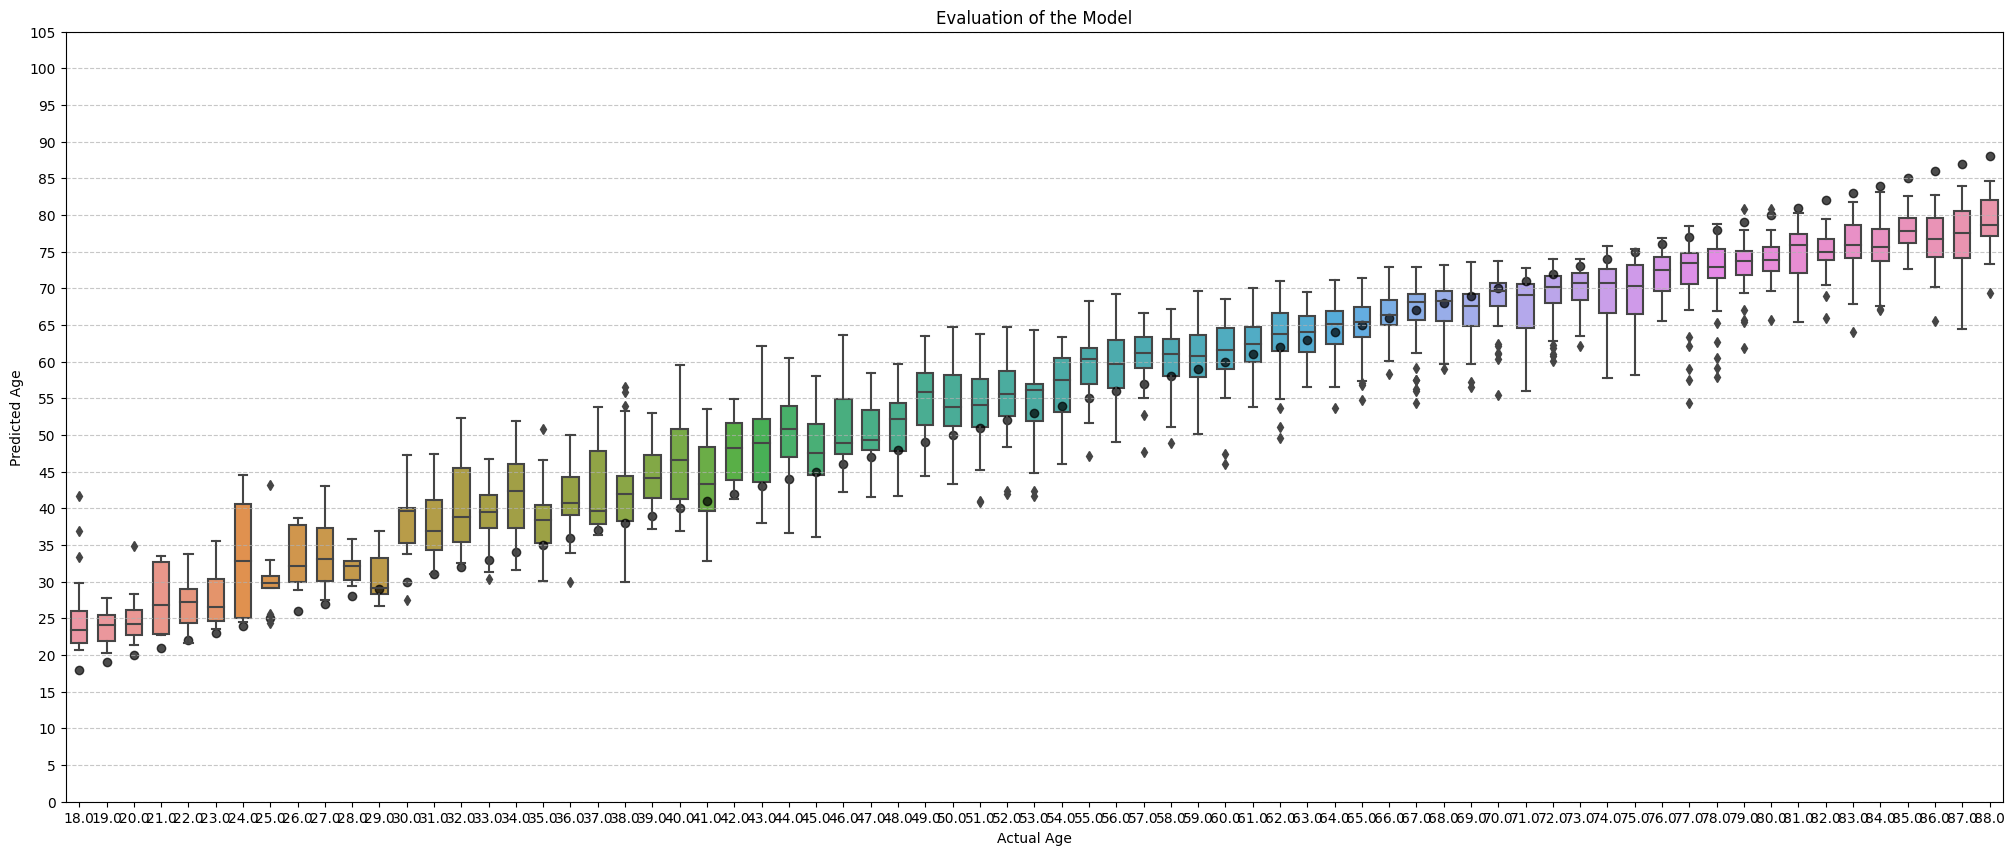

In [16]:
age_bar(cnn_age_model, X_test, y_test)

### MAE Metric

In [17]:
from sklearn.metrics import mean_absolute_error,accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

mean_absolute_error(y_test, predicted_age)

5.012911028803903